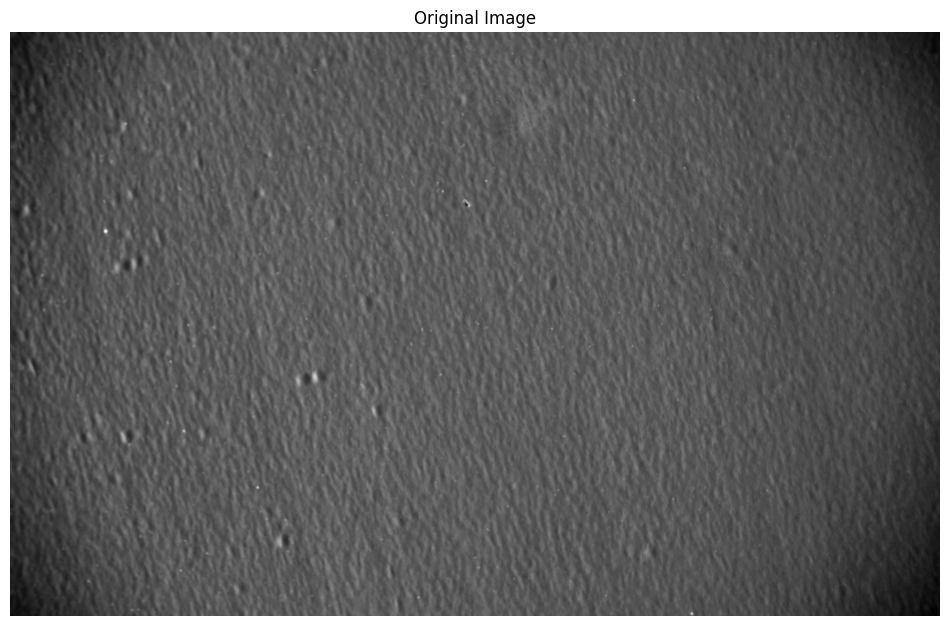

In [2]:
# 1. Import libraries and load image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

input_image = '/content/1.png'
img = cv2.imread(input_image, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,8))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()


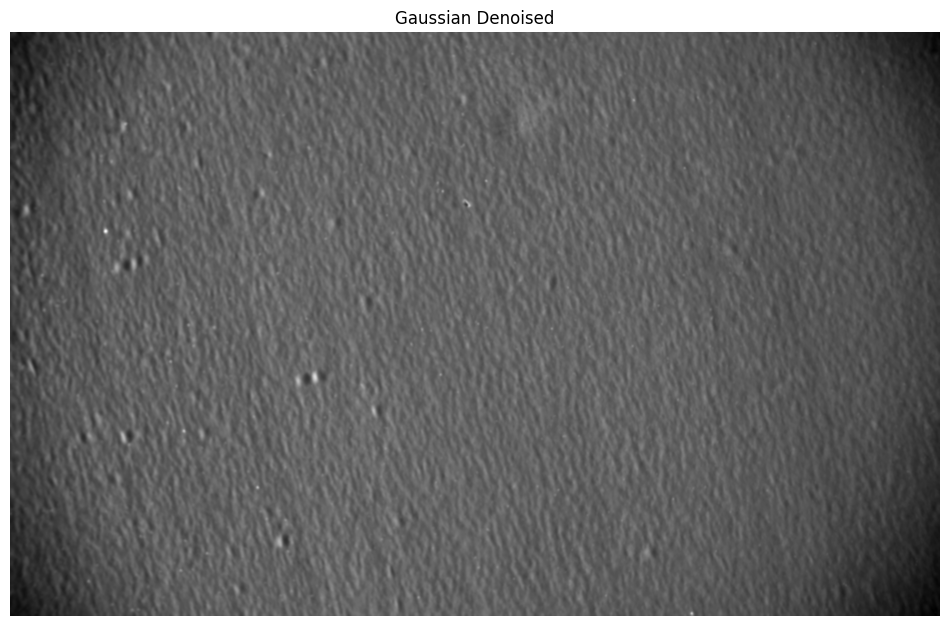

In [3]:
# 2. Gaussian denoising
img_blur = cv2.GaussianBlur(img, (7,7), 0)
plt.figure(figsize=(12,8))
plt.imshow(img_blur, cmap='gray')
plt.title('Gaussian Denoised')
plt.axis('off')
plt.show()


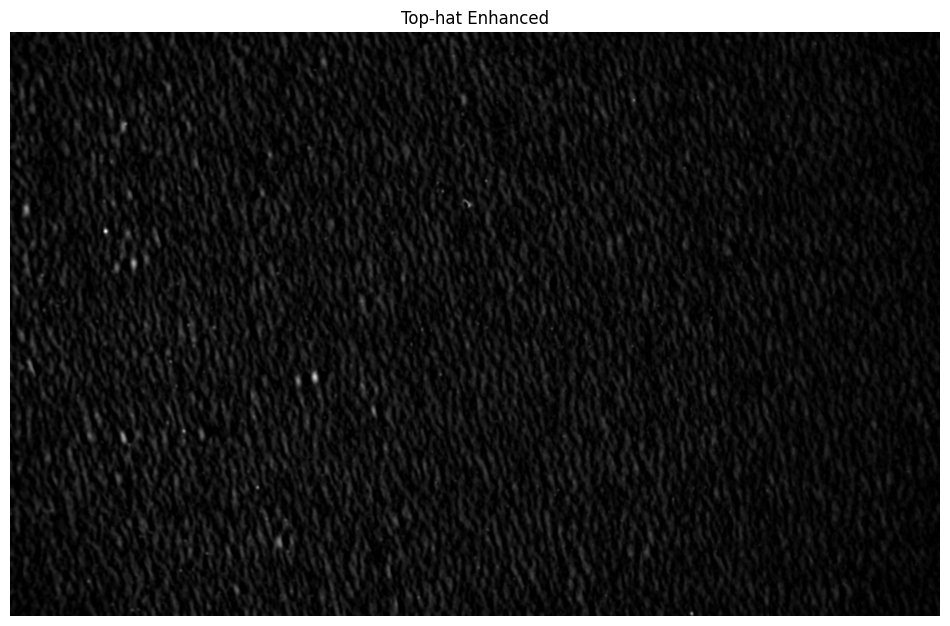

In [4]:
# 3. Top-hat filtering
kernel_size = 25
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
tophat = cv2.morphologyEx(img_blur, cv2.MORPH_TOPHAT, kernel)
plt.figure(figsize=(12,8))
plt.imshow(tophat, cmap='gray')
plt.title('Top-hat Enhanced')
plt.axis('off')
plt.show()


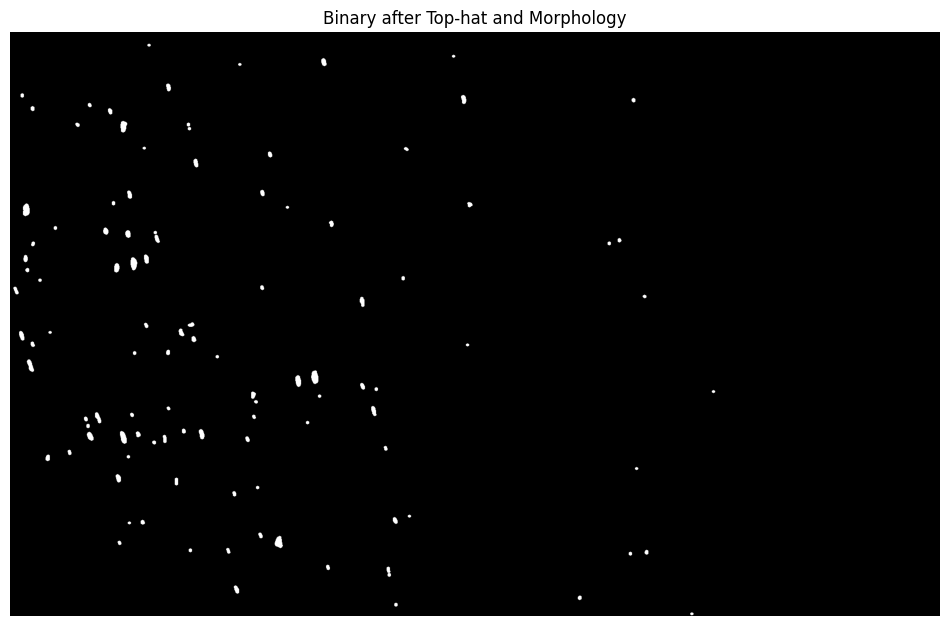

In [5]:
# 4. Thresholding and morphological denoising
_, binary = cv2.threshold(tophat, 20, 255, cv2.THRESH_BINARY)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7)))
plt.figure(figsize=(12,8))
plt.imshow(binary, cmap='gray')
plt.title('Binary after Top-hat and Morphology')
plt.axis('off')
plt.show()


In [6]:
# 5. Connected component analysis and region filtering
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
min_area = 50
max_area = 2000
regions = []
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    if not (min_area < area < max_area):
        continue
    mask = (labels == i).astype(np.uint8)
    maxval = (tophat * mask).max()
    meanval = (tophat * mask).sum() / mask.sum()
    cx, cy = centroids[i]
    regions.append({
        'center_x': int(cx),
        'center_y': int(cy),
        'rect_x': int(x),
        'rect_y': int(y),
        'width': int(w),
        'height': int(h),
        'score': float(maxval + meanval)
    })
# Sort by combined intensity, keep top N
N_keep = 200
# regions = sorted(regions, key=lambda r: -r['score'])[:N_keep]   # <-- removed top-N filtering

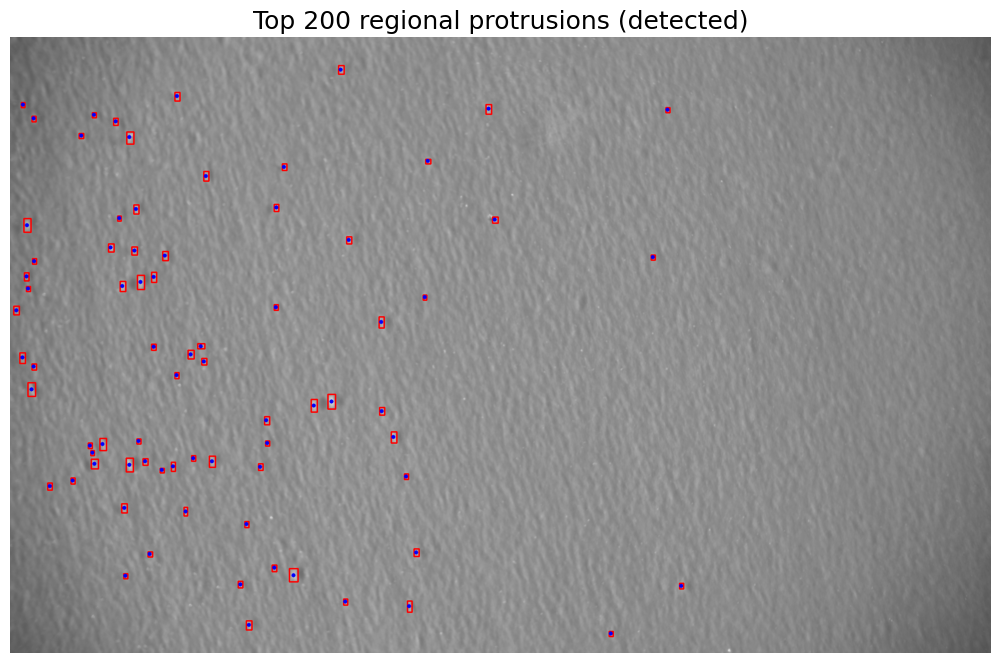

Detection results saved: /content/region_protrusions_result.png, /content/region_protrusions_coords.csv


In [7]:
# 6. Draw, save result image, and export CSV
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for r in regions:
    x, y, w, h = r['rect_x'], r['rect_y'], r['width'], r['height']
    cx, cy = r['center_x'], r['center_y']
    cv2.rectangle(output, (x, y), (x + w, y + h), (0,0,255), 2)
    cv2.circle(output, (cx, cy), 4, (255,0,0), -1)
plt.figure(figsize=(16,8))
plt.imshow(output[...,::-1])
plt.title("Top {} regional protrusions (detected)".format(N_keep), fontsize=18)
plt.xlabel("Detected region count: {}".format(len(regions)), fontsize=16, color="blue")
plt.axis("off")
plt.show()
cv2.imwrite('/content/region_protrusions_result.png', output)
import pandas as pd
df = pd.DataFrame(regions)
df.to_csv('/content/region_protrusions_coords.csv', index=False)
print("Detection results saved: /content/region_protrusions_result.png, /content/region_protrusions_coords.csv")


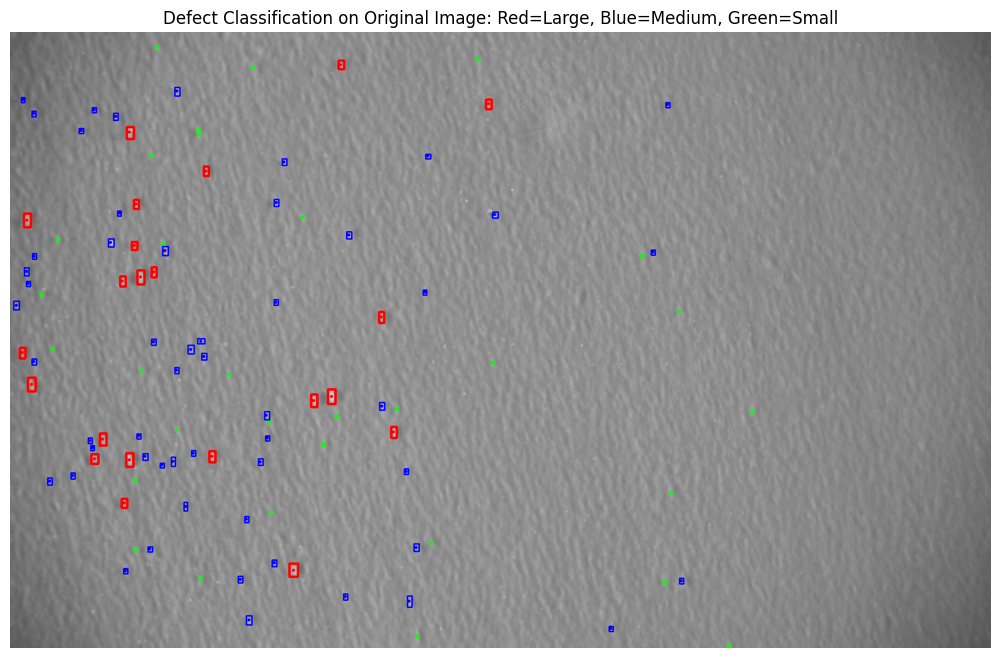

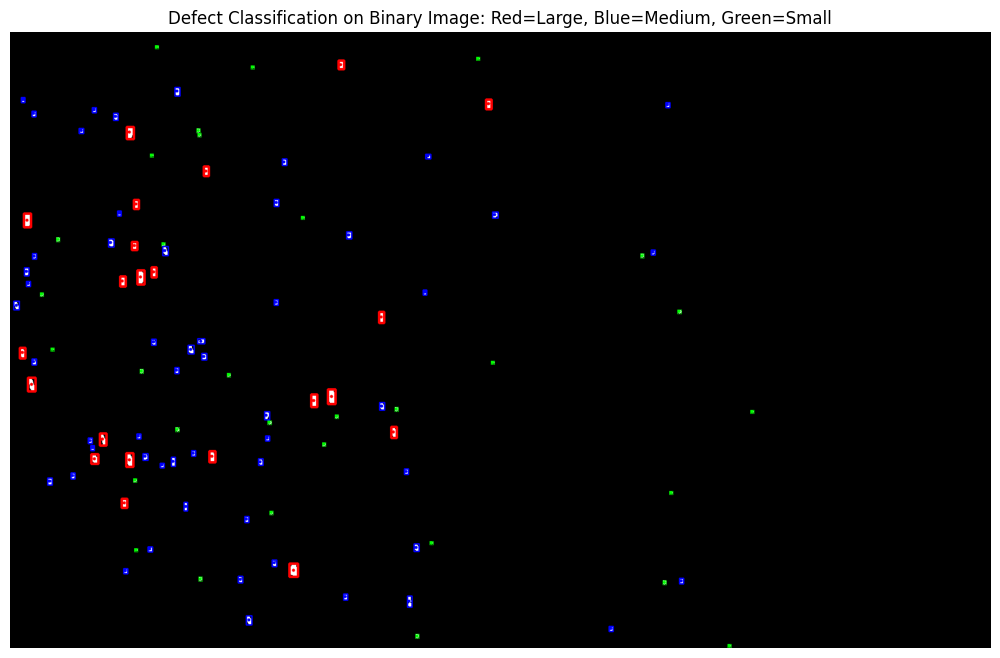

Exported ALL defect data to defect_area_classification_all.csv
Total: 107  (small=31, medium=54, large=22)


In [8]:
# 7. All-defect connected component classification and visualization on both original and binary image
import pandas as pd

# Locate the last binary variable and the original variable
binary_img = None
gray_img = None
for name in ['binary', 'binary_small', 'binary_mask', 'mask', 'bin_img']:
    if name in locals():
        binary_img = eval(name)
        break
for name in ['img', 'gray', 'original_img', 'gray_img']:
    if name in locals():
        gray_img = eval(name)
        break
if binary_img is None:
    raise RuntimeError('Please set your binary mask variable to binary_img!')
if gray_img is None:
    raise RuntimeError('Please set your grayscale original image variable to gray_img!')

if binary_img.max() > 1:
    _, binary_img = cv2.threshold(binary_img, 127, 255, cv2.THRESH_BINARY)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img)

# Automatic area grading thresholds
areas = stats[1:,cv2.CC_STAT_AREA]
if len(areas) < 5:
    thresh_small, thresh_medium = 200, 800
else:
    thresh_small = int(np.percentile(areas, 30))
    thresh_medium = int(np.percentile(areas, 80))

defect_list = []
for i in range(1, num_labels): # skip background
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]
    if area < thresh_small:
        size = 'small'
    elif area < thresh_medium:
        size = 'medium'
    else:
        size = 'large'
    defect_list.append({'x': int(x), 'y': int(y), 'w': int(w), 'h': int(h),
                       'area': int(area), 'cx': int(cx), 'cy': int(cy), 'size': size})

# Three-colour marks on the original and colour binary maps
if len(gray_img.shape)==2:
    orig_vis = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
else:
    orig_vis = gray_img.copy()
bin_vis = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
for d in defect_list:
    color = (0,255,0) if d['size']=='small' else (255,0,0) if d['size']=='medium' else (0,0,255)
    thickness = 1 if d['size']=='small' else 2 if d['size']=='medium' else 3
    cv2.rectangle(orig_vis, (d['x'], d['y']), (d['x']+d['w'], d['y']+d['h']), color, thickness)
    cv2.circle(orig_vis, (d['cx'], d['cy']), 3, color, -1)
    cv2.rectangle(bin_vis, (d['x'], d['y']), (d['x']+d['w'], d['y']+d['h']), color, thickness)
    cv2.circle(bin_vis, (d['cx'], d['cy']), 3, color, -1)

plt.figure(figsize=(16,8))
plt.imshow(orig_vis[...,::-1])
plt.title('Defect Classification on Original Image: Red=Large, Blue=Medium, Green=Small')
plt.xlabel(f"Total: {len(defect_list)}, small={sum(d['size']=='small' for d in defect_list)}, medium={sum(d['size']=='medium' for d in defect_list)}, large={sum(d['size']=='large' for d in defect_list)}", fontsize=14, color='blue')
plt.axis('off')
plt.show()
cv2.imwrite('/content/defect_area_classification_on_original.png', orig_vis)

plt.figure(figsize=(16,8))
plt.imshow(bin_vis[...,::-1])
plt.title('Defect Classification on Binary Image: Red=Large, Blue=Medium, Green=Small')
plt.xlabel(f"Total: {len(defect_list)}, small={sum(d['size']=='small' for d in defect_list)}, medium={sum(d['size']=='medium' for d in defect_list)}, large={sum(d['size']=='large' for d in defect_list)}", fontsize=14, color='blue')
plt.axis('off')
plt.show()
cv2.imwrite('/content/defect_area_classification_on_binary.png', bin_vis)

df = pd.DataFrame(defect_list)
df.to_csv('/content/defect_area_classification_all.csv', index=False)
print('Exported ALL defect data to defect_area_classification_all.csv')
print(f"Total: {len(defect_list)}  (small={sum(d['size']=='small' for d in defect_list)}, medium={sum(d['size']=='medium' for d in defect_list)}, large={sum(d['size']=='large' for d in defect_list)})")
